In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset
import skimage
%matplotlib inline

In [2]:
import numpy as np
import h5py


def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

(209, 64, 64, 3)
y = [0], it's a 'non-cat' picture.


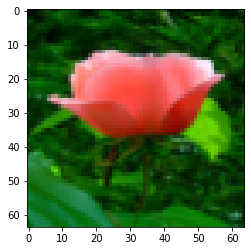

In [3]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()
print(train_set_x_orig.shape)
# Example of a picture
index = 3
example = train_set_x_orig[index]
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [4]:
print(train_set_x_orig.shape, train_set_y.shape, test_set_x_orig.shape, test_set_y.shape)

(209, 64, 64, 3) (1, 209) (50, 64, 64, 3) (1, 50)


### 得到数据

In [5]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[2]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


### 扁平化

In [6]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


### 归一化

In [7]:
train_set_x = train_set_x_flatten / 255.0
test_set_x = test_set_x_flatten / 255.0

### sigmoid函数

In [8]:
def sigmoid(z):
    s = 1.0 / (1 + np.exp(-z))
    return s
sigmoid(10)
sigmoid(0)

0.5

### 初始化参数

In [9]:
def initialize_parameters(dims):
    W = np.random.randn(dims, 1)
    b = 0
    assert(W.shape == (dims, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    return W, b

print(initialize_parameters(2))

(array([[0.16726918],
       [1.50755307]]), 0)


### 计算交叉熵，向前传播

In [10]:
m = train_set_x.shape[1]
n = train_set_x.shape[0]
print("m is: ", m)
print("n is: ", n)

X = train_set_x
Y = train_set_y
epsilon = 1e-5
learning_rate = 0.05

W, b = initialize_parameters(n)
w = W.reshape(n, 1)
print("w shape is: ", w.shape)
print("X shape is: ", X.shape)
print("Y shape is: ", Y.shape)
print("X.T length: ", len(X.T))
print("w length: ", len(w))

def propagate(X, Y, w, b):
    Z = np.dot(w.T, X) + b
    A = sigmoid(Z)
    J = -1.0 / m * np.sum(Y * np.log(A + epsilon) + (1 - Y) * np.log(1 - A + epsilon), axis=1)
    
#     print(J)
    J = np.squeeze(J)
    #     print(J)
    dw = 1.0 / m * np.dot(X, (A - Y).T)
    db = 1.0 / m * np.sum(A - Y, axis=1)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    assert(J.shape == ()) 
    grads = {
        "dw":dw,
        "db":db
    }
    return J, grads


m is:  209
n is:  12288
w shape is:  (12288, 1)
X shape is:  (12288, 209)
Y shape is:  (1, 209)
X.T length:  209
w length:  12288


### 优化，反向传播


In [11]:
def optimise(X, Y, w, b, learning_rate, nums=1000):
    JS = []
    for i in range(nums):
        J, grads = propagate(X, Y, w, b)
        dw = grads["dw"]
        db = grads["db"]
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        if i % 100 == 0:
            print(J)
            JS.append(J)
            
    params = {
        "w":w,
        "b":b
    }
    
    grads = {
        "dw":dw,
        "db":db
    }
    
    return JS, params, grads

JS, params, grads = optimise(X, Y, w, b, learning_rate, nums=1000)
# print(w)

        

4.351036600734207
3.3386438995990986
2.5415146216400886
1.8286138127315386
1.4488110603539146
2.070043210918487
0.5743357334407704
1.78949593985032
0.37954094842273417
1.4940533946381243


### 预测

In [12]:
def predict(X, w, b):
    m = X.shape[1]
    w = w.reshape(X.shape[0], 1)

    Y_predict = np.zeros((1, m))
    
    Z = np.dot(w.T, X) + b
    A = sigmoid(Z)
    
    [print(x) for x in A]
    for i in range(A.shape[1]):
        if A[0, i] >= 0.5:
            Y_predict[0, i] = 1
        else:
            Y_predict[0, i] = 0
            
    assert(Y_predict.shape == (1, m))
    
    return Y_predict

# print ("predictions = " + str(predict(X, w, b)))
    

### 综合起来

In [13]:
def model(X_train, Y_train, X_test, Y_test, nums=2000, learning_rate=0.5):
    W, b = initialize_parameters(X_train.shape[0])
    w = W.reshape(X_train.shape[0], 1)
    JS, params, grads = optimise(X_train, Y_train, w, b, learning_rate, nums)
    w = params["w"]
    b = params["b"]
    
    Y_predict_train = predict(X_train, w, b)
    Y_predict_test = predict(X_test, w, b)
    
    # 打印准确率
    print("The accuracy of X_train is: ", 1 - np.mean(np.abs(Y_train - Y_predict_train)))
    print("The accuracy of X_test is: ", 1 - np.mean(np.abs(Y_test - Y_predict_test)))
    
    d = {
        "costs" : JS,
        "Y_predict_train" : Y_predict_train,
        "Y_predict_test" : Y_predict_test,
        "w" : w,
        "b" : b,
        "learning_rate" : learning_rate,
        "nums" : nums
    }
    return d
    

d = model(train_set_x, train_set_y, test_set_x, test_set_y, nums=5000, learning_rate=0.01)

3.651872836321716
4.421386320996598
4.004330209418159
3.498807707672867
3.1331669827534183
2.859217888226871
2.60768287144981
2.375777653691685
2.1589430329151136
1.9507376211928071
1.7527678562640567
1.5613245875442392
1.375587829916202
1.2032990258967802
1.053266259904365
0.9231968178806864
0.8077408732037009
0.7064355328069284
0.6153066414588885
0.5308811000581155
0.4579078985786885
0.39616542674471994
0.34327358864092344
0.2996677913713735
0.2642068607548199
0.23405085707847492
0.2078209115621493
0.1849761601466045
0.1652323218921957
0.14831857581423846
0.1339625001121346
0.12184932506403523
0.11160407257660256
0.10285408128298464
0.0952846256306705
0.08865231848615425
0.08277557549219283
0.07752009546525308
0.07278614459503077
0.06849885484176299
0.0646010789324273
0.06104813326703207
0.057803928053239195
0.05483817240092298
0.05212445475552502
0.049639034443364226
0.04736017414953136
0.045267836739226186
0.04334358609774371
0.041570570145784885
[9.76779496e-02 1.01084370e-02 9.75

### 画出代价函数的变化曲线

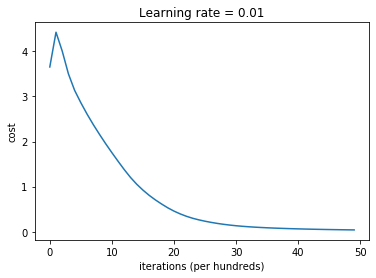

In [14]:
costs = np.squeeze(d["costs"])
plt.plot(costs)
plt.ylabel("cost")
plt.xlabel("iterations (per hundreds)")
plt.title("Learning rate = " + str(d["learning_rate"]))
plt.show()

In [15]:
import math
print(math.exp(2))

7.38905609893065


### hello

$$f(x)=sin(x)$$

In [16]:
import requests
url = "https://www.qq.com"
r = requests.get(url)
print(r.encoding)

ModuleNotFoundError: No module named 'requests'

In [ ]:
print(r.text)